# Fine-tuning for Semantic Segmentation - Results

This contains some code for inspecting the outputs of the model fine-tuned for semantic segmentation.


In [127]:
from point2vec.datasets import LArNetDataModule
import matplotlib.pyplot as plt
import torch
import numpy as np

# Turn off gradient tracking so we don't run out of memory
torch.set_grad_enabled(False);

Set up the dataset as usual

In [128]:
dataset = LArNetDataModule(
    data_path=f'/sdf/home/y/youngsam/data/dune/larnet/h5/DataAccessExamples/train/generic_v2*.h5',
    batch_size=24,
    num_workers=0,
    dataset_kwargs={
        'emin': 1.0e-6,                      # min energy for log transform
        'emax': 20.0,                        # max energy for log transform
        'energy_threshold': 0.13,            # remove points with energy < 0.13
        'remove_low_energy_scatters': True,  # remove low energy scatters (PID=4)
        'maxlen': -1,                        # max number of events to load
        'normalize': True,                   # normalize point cloud to unit sphere
    }
)
dataset.setup()

[DATASET] self.emin=1e-06, self.emax=20.0, self.energy_threshold=0.13, self.normalize=True, self.remove_low_energy_scatters=True
[DATASET] Building index
[DATASET] 864064 point clouds were loaded
[DATASET] 10 files were loaded
[DATASET] self.emin=1e-06, self.emax=20.0, self.energy_threshold=0.13, self.normalize=True, self.remove_low_energy_scatters=True
[DATASET] Building index
[DATASET] 8531 point clouds were loaded
[DATASET] 1 files were loaded


Instantiate pre-trained model

In [129]:
from point2vec.models import Point2VecPartSegmentation
from glob import glob
import os
import pytorch_lightning as pl

def get_newest_ckpt(ckpt_path):
    ckpt_path = glob(f'{ckpt_path}/**/*.ckpt')
    newest_ckpt = max(ckpt_path, key=os.path.getctime)
    return newest_ckpt

wandb_run_id = '4intrcwf'
ckpt_path = f'/sdf/home/y/youngsam/sw/dune/representations/point2vec/point2vec-Part-Segmentation-LArNet-med-noLED/{wandb_run_id}'

# unfortunately the part semgentation needs to be attached to a trainer and a datamodule
# so we need to do a little bit of gymnastics to load the checkpoint
def load_from_checkpoint(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location="cpu")
    hyper_parameters = checkpoint["hyper_parameters"]
    model = Point2VecPartSegmentation(**hyper_parameters)
    trainer = pl.Trainer()
    model.trainer = trainer
    model.trainer.datamodule = dataset
    model.setup()
    print('loading segmentation checkpoint')
    model.load_state_dict(checkpoint["state_dict"])
    return model

model = load_from_checkpoint(get_newest_ckpt(ckpt_path)).cuda()
model.eval();

/lscratch/youngsam/tmp/ipykernel_1066063/1353040844.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cpu")
GPU available

Loading pretrained checkpoint from '/sdf/home/y/youngsam/sw/dune/representations/point2vec/PointMAE-Pretraining-LArNet-5voxel/fjnp0snd/checkpoints/epoch=30-step=100000.ckpt'.
Missing keys: ['upsampling.mlp_convs.0.weight', 'upsampling.mlp_convs.1.weight', 'upsampling.mlp_bns.0.weight', 'upsampling.mlp_bns.0.bias', 'upsampling.mlp_bns.0.running_mean', 'upsampling.mlp_bns.0.running_var', 'upsampling.mlp_bns.1.weight', 'upsampling.mlp_bns.1.bias', 'upsampling.mlp_bns.1.running_mean', 'upsampling.mlp_bns.1.running_var', 'seg_head.conv1.weight', 'seg_head.bn1.weight', 'seg_head.bn1.bias', 'seg_head.bn1.running_mean', 'seg_head.bn1.running_var', 'seg_head.conv2.weight', 'seg_head.bn2.weight', 'seg_head.bn2.bias', 'seg_head.bn2.running_mean', 'seg_head.bn2.running_var', 'seg_head.conv3.weight', 'seg_head.conv3.bias', 'loss_func.weight']
Unexpected keys: ['increase_dim.0.weight', 'increase_dim.0.bias']
🔥  Performing linear probing.
loading segmentation checkpoint


The forward pass of the model returns the class logits and a point mask. We can get predictions by taking the argmax of the logits.

In [130]:
points, lengths, labels, _ = next(iter(dataset.train_dataloader()))
B, N, C = points.shape
points = points.cuda()   # (B, N, 4)
lengths = lengths.cuda() # (B,)
labels = labels.cuda().squeeze(-1) # (B, N)
x, point_mask = model(points, lengths)
pred = torch.max(x, dim=-1).indices

We can now get the accuracy by comparing the predictions to the true labels.

In [131]:
pred = pred[point_mask]
labels = labels[point_mask]
accuracy = (pred==labels).float().mean()
print('overall accuracy', accuracy)

overall accuracy tensor(0.9670, device='cuda:0')


We can also plot the predicted and true labels for all points in a single event for visual comparison:

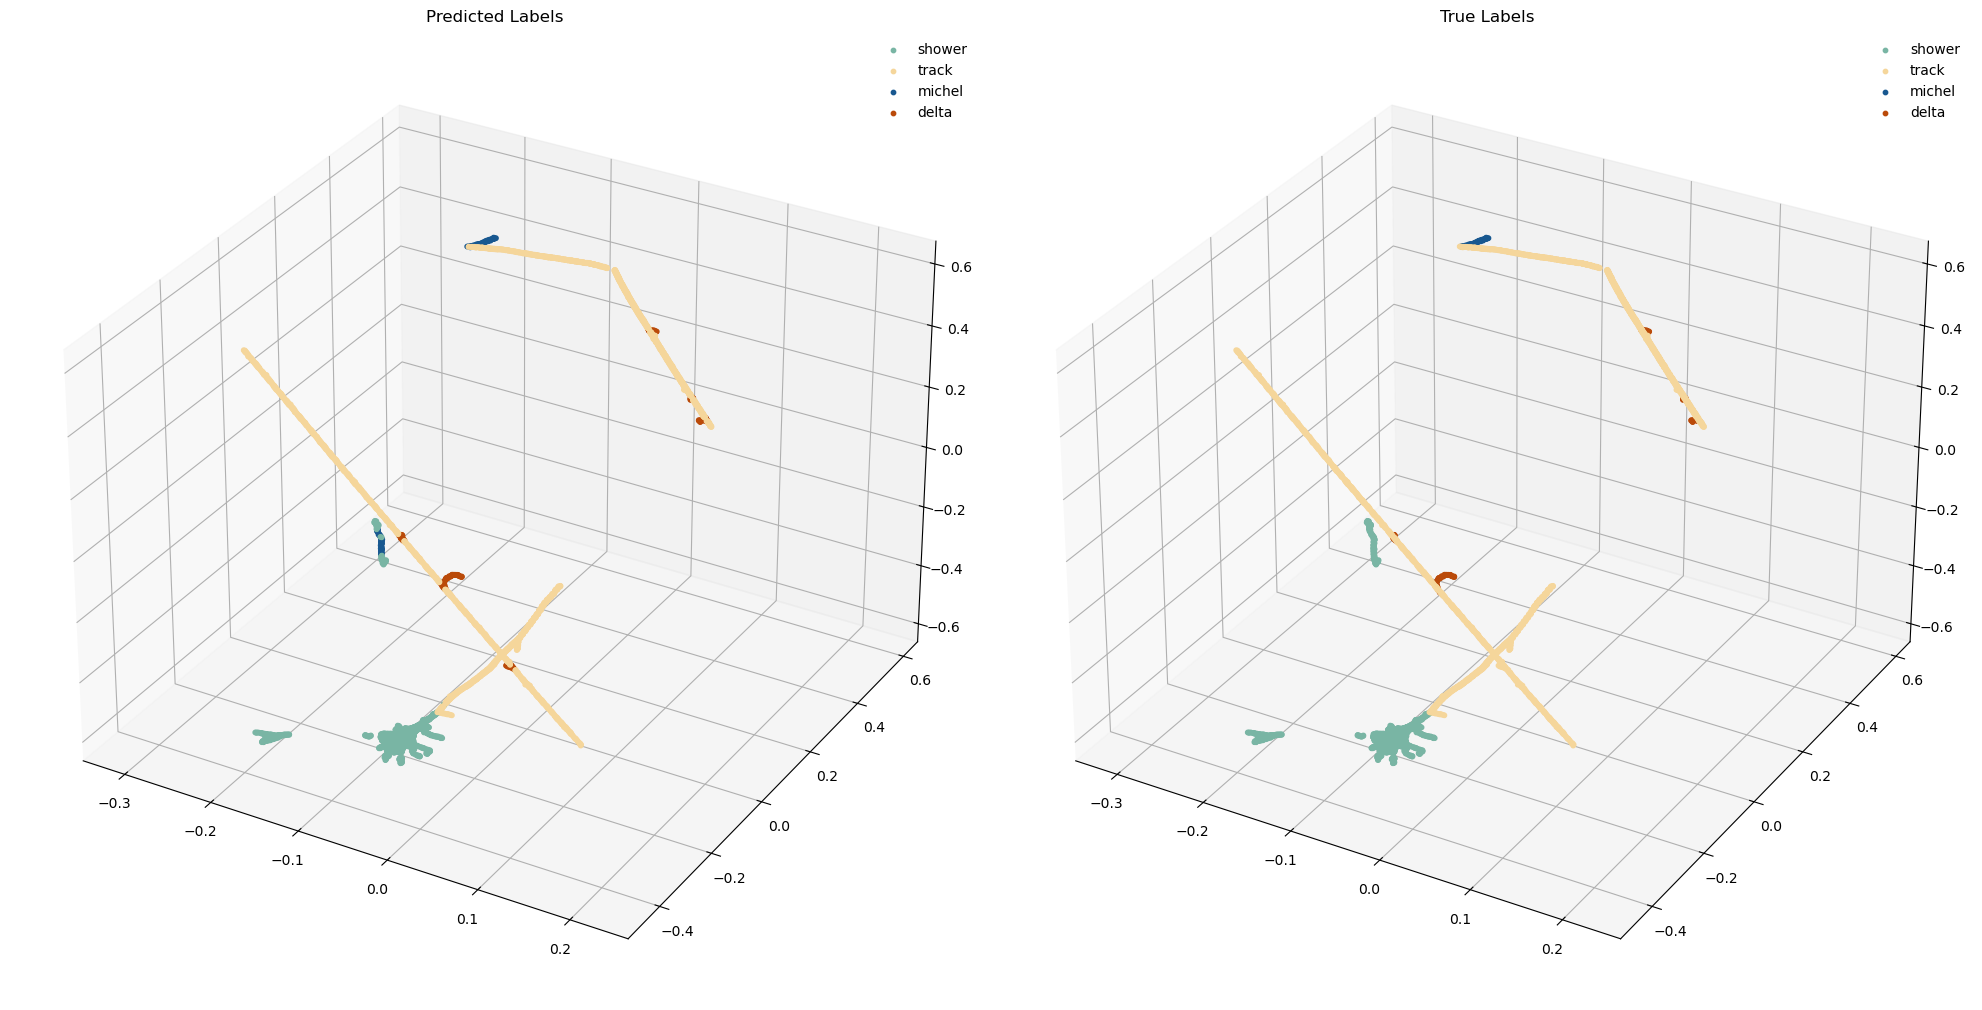

In [132]:
import matplotlib.pyplot as plt

# Convert prediction and labels from a flat tensor back to groups
group_pred = torch.zeros_like(points[:, :, 0]).long()
group_pred[point_mask] = pred

group_labels = torch.zeros_like(points[:, :, 0]).long()
group_labels[point_mask] = labels

group_pred = group_pred.cpu().numpy()
points = points.cpu().numpy()
group_labels = group_labels.cpu().numpy()

# plot the predicted and true labels for a single event
event_idx = 1

fig= plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

seg_class_to_category = model.trainer.datamodule.seg_class_to_category  # contains the class names
palette = ['#79B5A4', '#F5D69B', '#185890', '#BA4A09']
label_to_color = {i: palette[i] for i in range(len(palette))}

# Plot predicted labels
for c in seg_class_to_category.keys():
    curr_points = points[event_idx, :lengths[event_idx], :]
    curr_pred = group_pred[event_idx, :lengths[event_idx]]

    ax1.scatter(
        curr_points[curr_pred==c, 0],
        curr_points[curr_pred==c, 1],
        curr_points[curr_pred==c, 2],
        c=label_to_color[c],
        s=10,
        alpha=1,
        label=seg_class_to_category[c]
    )
ax1.set_title('Predicted Labels')
ax1.legend(frameon=False)

# Plot true labels
for c in seg_class_to_category.keys():
    curr_points = points[event_idx, :lengths[event_idx], :]
    curr_labels = group_labels[event_idx, :lengths[event_idx]]

    ax2.scatter(
        curr_points[curr_labels==c, 0],
        curr_points[curr_labels==c, 1],
        curr_points[curr_labels==c, 2],
        c=label_to_color[c],
        s=10,
        alpha=1,
        label=seg_class_to_category[c]
    )
ax2.set_title('True Labels')
ax2.legend(frameon=False)
plt.tight_layout()
plt.show()


We can also get per-class metrics:

In [124]:
from torchmetrics import Accuracy, Precision

macc = Accuracy('multiclass', num_classes=model.num_seg_classes, average="macro", ignore_index=-1).cuda()
mprec = Precision('multiclass', num_classes=model.num_seg_classes, average="macro", ignore_index=-1).cuda()

# also get per-class accuracy and precision
class_acc = Accuracy('multiclass', num_classes=model.num_seg_classes, average=None, ignore_index=-1).cuda()
class_prec = Precision('multiclass', num_classes=model.num_seg_classes, average=None, ignore_index=-1).cuda()

# get metrics for the current event
macc, mprec, class_acc, class_prec = macc(pred, labels), mprec(pred, labels), class_acc(pred, labels), class_prec(pred, labels)

print('Macro Accuracy:', macc.item())
print('Macro Precision:', mprec.item())
print('Class Accuracy:', {seg_class_to_category[i]: class_acc[i].item() for i in range(model.num_seg_classes)})
print('Class Precision:', {seg_class_to_category[i]: class_prec[i].item() for i in range(model.num_seg_classes)})

Macro Accuracy: 0.9527058005332947
Macro Precision: 0.7578431367874146
Class Accuracy: {'shower': 0.9846216440200806, 'track': 0.9455851912498474, 'michel': 0.916208803653717, 'delta': 0.9644076228141785}
Class Precision: {'shower': 0.9985758662223816, 'track': 0.9921466112136841, 'michel': 0.5553705096244812, 'delta': 0.4852796792984009}


And plot them out!

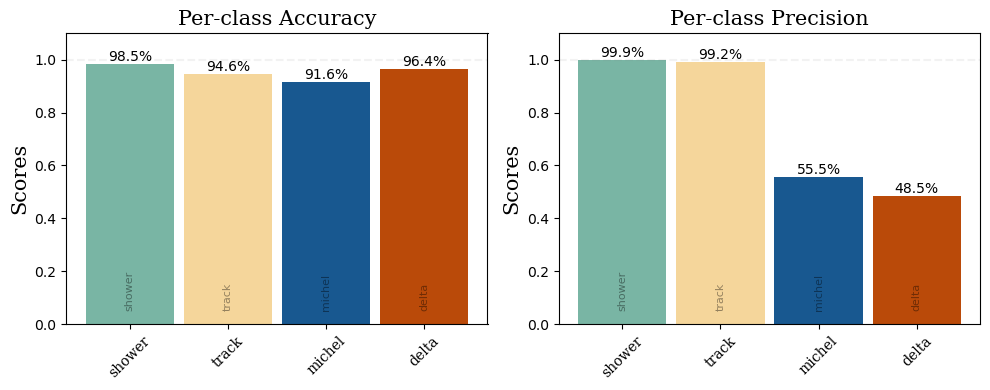

In [125]:
import matplotlib.pyplot as plt
import numpy as np

def darken(color, percentage):
    """
    Darkens the given color by the specified percentage.
    """
    color = color.lstrip('#')
    rgb = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
    darkened_rgb = tuple(int(c * (1 - percentage)) for c in rgb)
    darkened_color = '#{:02x}{:02x}{:02x}'.format(*darkened_rgb)
    return darkened_color

# Extract accuracy and precision values for each class
acc_values = class_acc.cpu()
prec_values = class_prec.cpu()
classes = list(seg_class_to_category.values())

# Create two bar plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Define bar width
bar_width = 0.9
index = np.arange(len(acc_values))  # Indices for each class

# Plot bars for class accuracy
for i, (acc, color) in enumerate(zip(acc_values, palette)):
    ax1.bar(index[i], acc, bar_width, label=f'{classes[i]} ACC', color=color)
    # Add values above the bars
    ax1.text(index[i], acc, f'{acc:.1%}', ha='center', va='bottom')
    # Add class names inside the bars, rotated by 90 degrees
    ax1.text(index[i], 0.05, classes[i], ha='center', va='bottom', rotation=90, fontsize=8, color=darken(color, 0.4))

# Plot bars for class precision
for i, (prec, color) in enumerate(zip(prec_values, palette)):
    ax2.bar(index[i], prec, bar_width, label=f'{classes[i]} Precision', color=color)
    # Add values above the bars
    ax2.text(index[i], prec, f'{prec:.1%}', ha='center', va='bottom')
    # Add class names inside the bars, rotated by 90 degrees
    ax2.text(index[i], 0.05, classes[i], ha='center', va='bottom', rotation=90, fontsize=8, color=darken(color, 0.4))

# Add labels, title, and legend for accuracy plot
ax1.set_ylabel('Scores', fontsize=15, fontname='serif')
ax1.set_title('Per-class Accuracy', fontsize=15, fontname='serif')
ax1.set_xticks(index)
ax1.set_ylim(0, 1.1)
ax1.set_xticklabels(classes, fontsize=10, fontname='serif', rotation=45)
ax1.axhline(1.0, color='grey', linestyle='--', alpha=0.1)

# Add labels, title, and legend for precision plot
ax2.set_ylabel('Scores', fontsize=15, fontname='serif')
ax2.set_title('Per-class Precision', fontsize=15, fontname='serif')
ax2.set_xticks(index)
ax2.set_ylim(0, 1.1)
ax2.set_xticklabels(classes, fontsize=10, fontname='serif', rotation=45)
ax2.axhline(1.0, color='grey', linestyle='--', alpha=0.1)

plt.tight_layout()
plt.show()
